In [ ]:
import os
import io
import numpy as np
from numpy.random import rand
import torch
from torchsummary import summary
import pickle
import matplotlib.pyplot as plt
from minetest.adapter import *
from colab.conv_gan import *
 
# define model parameters
output_shape = 16
noise_dim = 200
feature_dim = 64

generator = ConvGenerator(noise_dim, feature_dim)
discriminator = ConvDiscriminator(feature_dim, output_shape)

G_PATH = os.getcwd() + '/models/states/G.pth'
D_PATH = os.getcwd() + '/models/states/ConvGAN18-09-2022-22-09-38_D.pth'
generator.load_state_dict(torch.load(G_PATH, map_location=torch.device("cpu")), strict=False)
discriminator.load_state_dict(torch.load(D_PATH, map_location=torch.device("cpu")), strict=False)

summary(generator, (1, noise_dim))
summary(discriminator, (1, output_shape, output_shape, output_shape))

start_training(
    generator,
    discriminator,
    model_type="WGANgp",
    data_path=os.getcwd() + "/dataset/output/segmentation_3d_data.pkl",
    generator_lr=0.0025,
    discriminator_lr=0.00005,
    n_epochs=1,
    batch_size=32,
    noise_dim=noise_dim,
    live_mode=False)

<All keys matched successfully>

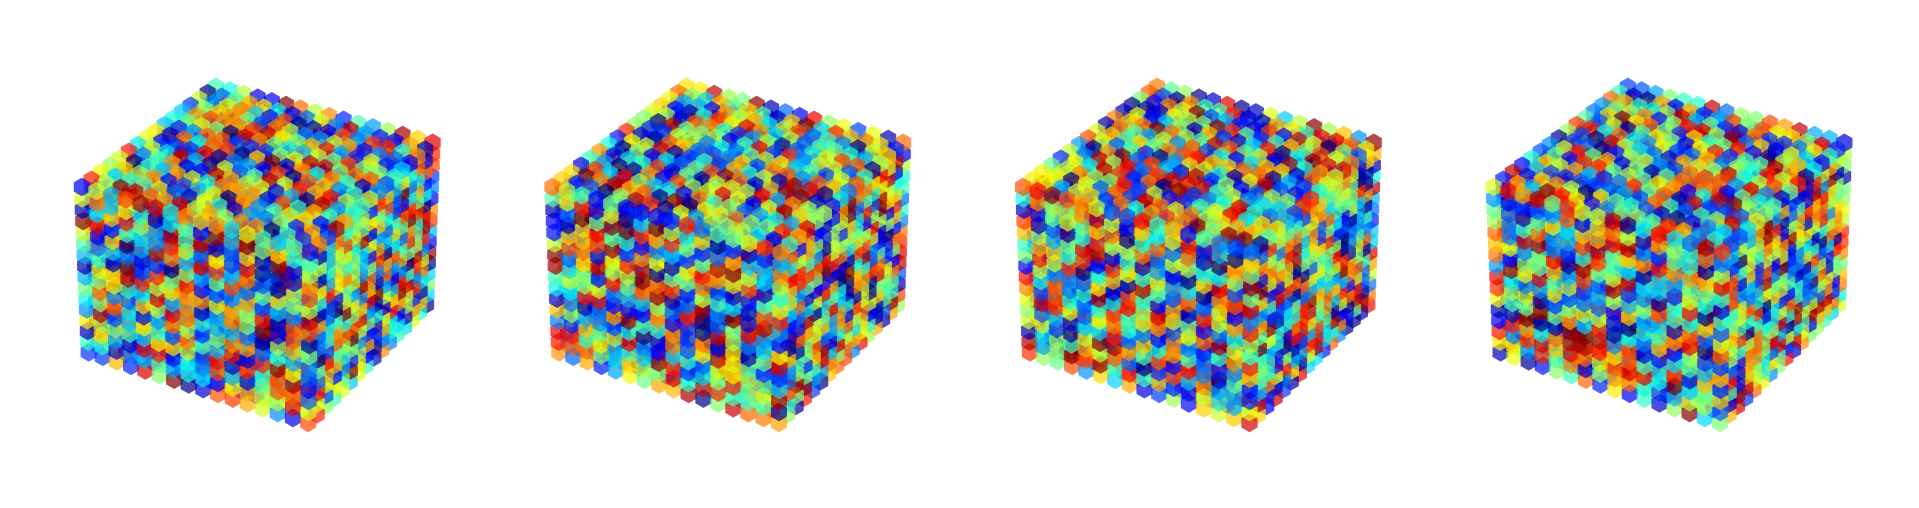

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits.mplot3d
import numpy as np

NUM_SAMPLES = 4
# x = latent_vector(NUM_SAMPLES, noise_dim)
# samples = generator(x).cpu().data[:NUM_SAMPLES].squeeze().numpy()
# samples = samples * 0.5 + 0.5

samples = np.random.rand(4, 16, 16, 16)

plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=0.05, hspace=0.05)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
for i, sample in enumerate(samples):
    x, y, z = sample.nonzero()
    ax = plt.subplot(gs[i], projection='3d')
    ax.scatter3D(x, y, z, zdir='z', c=sample[x,y,z], cmap='jet', marker="h", alpha=0.7, linewidth=0.)
    ax.axis('off')
# plt.savefig(os.getcwd() + 'sample_@epoch{}.png'.format(str(1)))
plt.show()
plt.close()

In [ ]:
with open(os.getcwd() + "/dataset/output/structures.pkl",'rb') as f:
    data = pickle.load(f)
mta = MinetestAdapter()
mta.connect()

In [ ]:
# value used for up-scaling data
MAX_ID = 32

# number of noise distributions to generate
# equals the number generated of outputs
LATENT_VECTORS = 1

generator.eval()
x = torch.Tensor(LATENT_VECTORS, noise_dim).normal_(0.0, 1.0)
s = generator(x).detach().numpy() * MAX_ID
mta.build(np.fix(s), (0, 0, 0))

(16, 16, 16)


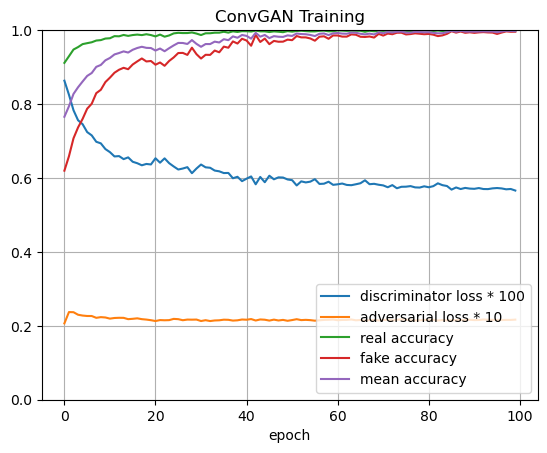

In [ ]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

with open(os.getcwd() + '/models/logs/ConvGAN18-09-2022-22-09-38_log.pkl','rb') as f:
    stats = CPU_Unpickler(f).load()

x = list(range(len(stats['dl'])))
fig, ax = plt.subplots()
ax.plot(x, [val.detach() * 100 for val in stats['dl']], label='discriminator loss * 100')
ax.plot(x, [val.detach() * 10 for val in stats['al']], label='adversarial loss * 10')
ax.plot(x, stats['ra'], label='real accuracy')
ax.plot(x, stats['fa'], label='fake accuracy')
ax.plot(x, stats['ma'], label='mean accuracy')
plt.ylim(0, 1)
plt.legend(loc="lower right")

ax.set(xlabel='epoch', title='ConvGAN Training')
ax.grid()

fig.savefig("conv_gan_training.png")
plt.show()

In [ ]:
# label flip and noisify algorithm
FLIP_CHANCE = 1.5
NOISE_LEVEL = 0.4
OFFSET = 0.8
flips = np.floor(rand(3) * FLIP_CHANCE) * OFFSET
real = rand(3).astype(np.float32) * NOISE_LEVEL + OFFSET
fake = rand(3).astype(np.float32) * NOISE_LEVEL
real -= flips
fake += flips

print(real)
print(fake)
print(flips)


[0.23538752 0.9114854  0.9910328 ]
[1.1245997  0.07674543 0.00260577]
[0.8 0.  0. ]
